In [ ]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR100
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.io import read_image
from torchvision import transforms, models

## other libraries
from PIL import Image
import cv2
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from copy import deepcopy
import math

## Hyperparameters


In [ ]:
num_classes = 10
lr = 0.001
batch_size = 32

## Choice Task 3: Data Augmentation


In [ ]:
# transformations for training data
transformations = transforms.Compose(
    [
        transforms.ToTensor(),
        # data augmentation
        transforms.RandomApply(
            [
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(
                    brightness=0.2, contrast=0.1, saturation=0.1, hue=0.01
                ),
            ],
            p=0.2,
        ),
    ]
)

# Task 1: Dataloaders CIFAR10


In [ ]:
# apply data augmentation to training data only
train_data = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transformations
)
test_data = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transforms.ToTensor()
)
val_data = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)

train_split, val_split = torch.utils.data.random_split(train_data, [40000, 10000])
train_data = torch.utils.data.Subset(train_data, train_split.indices)
val_data = torch.utils.data.Subset(val_data, val_split.indices)

# Dataloaders
trainDL = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valDL = DataLoader(val_data, batch_size=batch_size, shuffle=False)
testDL = DataLoader(test_data, batch_size=1, shuffle=False)

100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


# Task 2: CIFAR10 models


## CIFAR10_lenet


In [ ]:
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.weights_init()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Linear(400, 120)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    # init weights with nn.init.kaiming_normal
    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

## CIFAR10_model1 (Batch Normalization)


In [ ]:
class LeNet1(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.weights_init()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(6)  # added batch normalization
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)  # added batch normalization
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Linear(400, 120)
        self.bn3 = nn.BatchNorm1d(120)  # added batch normalization
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # added batch normalization
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)  # added batch normalization
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.conv3(x)
        x = self.bn3(x)  # added batch normalization
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

## CIFAR10_model2 (Dropout)


In [ ]:
class LeNet2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.weights_init()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(6)  # added batch normalization
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)  # added batch normalization
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Linear(400, 120)
        self.bn3 = nn.BatchNorm1d(120)  # added batch normalization
        self.fc1 = nn.Linear(120, 84)
        self.drop1 = nn.Dropout(0.2)  # added dropout
        self.fc2 = nn.Linear(84, num_classes)

    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop1(x)  # added dropout
        x = self.fc2(x)

        return x

## Choice Task 1: Learning Rate Scheduler


In [ ]:
def lr_scheduler(optimizer, epoch=0):
    """
    function that decreases optimizer's learning rate every 5 epochs
    of training by half
    """
    if epoch > 0 and epoch % 5 == 0:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5
        print("Learning rate decreased")
    return optimizer


def plot_lr(lr_values_list):
    """
    plot learning rate values per epoch
    """
    plt.figure(figsize=(10, 5))
    plt.plot(
        range(1, len(lr_values_list) + 1),
        lr_values_list,
        marker="o",
        label="Learning Rate",
    )
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Decreasing Learning Rate per Epoch")
    plt.legend()
    plt.show()
    plt.close()

# Plot Results


In [ ]:
def plot_loss(train_losses, val_losses):
    """
    plot training and validation loss per epoch
    train_losses: training losses per epoch
    val_losses: validation losses per epoch
    """
    epochs = len(train_losses)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss per Epoch")
    plt.legend()
    plt.show()
    plt.close()


def plot_accuracy(train_accuracies, val_accuracies):
    """
    plot training and validation accuracy per epoch
    train_accuracies: training accuracy per epoch
    val_accuracies: validation accuracy per epoch
    """
    epochs = len(train_accuracies)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim([0, 100])
    plt.title("Training and Validation Accuracy per Epoch")
    plt.legend()
    plt.show()
    plt.close()

# Training and Validation


In [ ]:
def train_model(model, trainDL, valDL, epochs, lr=0.001, save_path="/model.pt"):
    """
    function that implements training and saves model weights

    model: CNN model to be trained
    trainDL: training set dataloader
    valDL: validation set dataloader
    epochs: max numr of epochs
    save_path: path to save model weights
    """
    # if gpu is available use gpu during training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # CE Loss , Adam optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # lists to store loss, accuracy and learning rate values
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    lr_history = []

    for epoch in range(epochs):

        model.train()
        train_loss, val_loss = 0, 0
        train_correct, val_correct = 0, 0
        optimizer = lr_scheduler(optimizer, epoch)
        lr_history.append(optimizer.param_groups[0]["lr"])

        for batch, labels in trainDL:
            batch, labels = batch.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(batch)
            # batch loss
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            # add to epoch loss
            train_loss += loss.item()
            # accuracy calculation
            _, predicted = torch.max(output, 1)
            train_correct += (predicted == labels).sum().item()

        # validation performance
        model.eval()
        with torch.no_grad():
            for batch, labels in valDL:
                batch, labels = batch.to(device), labels.to(device)
                output = model(batch)
                # batch loss
                loss = criterion(output, labels)
                val_loss += loss.item()
                # accuracy calculation
                _, predicted = torch.max(output, 1)
                val_correct += (predicted == labels).sum().item()

        # train, val loss, accuracy here
        train_acc = 100 * train_correct / len(trainDL.dataset)
        val_acc = 100 * val_correct / len(valDL.dataset)

        train_epoch_loss = train_loss / len(trainDL)
        val_epoch_loss = val_loss / len(valDL)

        print(
            f"Epoch {epoch+1}/{epochs}, Train Loss:{train_epoch_loss:.4f}, Train Accuracy:{train_acc:.2f}%, Val Loss:{val_epoch_loss:.4f}, Val Acc:{val_acc:.2f}%"
        )
        # append epoch metrics to lists
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_losses.append(train_epoch_loss)
        val_losses.append(val_epoch_loss)

        # early stopping
        if (
            val_epoch_loss >= min(val_losses)
            and epoch - np.argmin(np.array(val_losses)) >= 6
        ):
            torch.save(model.state_dict(), save_path)
            print(f"Model weights saved at {save_path}\n")
            break
    print(f"top-1 training accuracy: {max(train_accuracies)}")
    print(f"top-1 validation accuracy: {max(val_accuracies)}\n")
    plot_lr(lr_history)
    plot_accuracy(train_accuracies, val_accuracies)
    plot_loss(train_losses, val_losses)

    return train_losses, train_accuracies, val_losses, val_accuracies


def evaluate(model, dataloader):
    """
    function that evaluates model on test data
    model: CNN model to be evaluated
    dataloader: dataloader for test data
    """
    # if gpu is available use it
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()
    correct, total = 0, 0
    y_preds, y_true = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            # accuracy calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # predictions & labels for cm
            y_preds.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    cm = confusion_matrix(y_true=y_true, y_pred=y_preds)

    return accuracy, cm

## CIFAR10_lenet training


LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Linear(in_features=400, out_features=120, bias=True)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 1/100, Train Loss:1.8395, Train Accuracy:31.96%, Val Loss:1.6515, Val Acc:40.38%
Epoch 2/100, Train Loss:1.5648, Train Accuracy:42.90%, Val Loss:1.5220, Val Acc:45.33%
Epoch 3/100, Train Loss:1.4324, Train Accuracy:48.36%, Val Loss:1.3927, Val Acc:50.74%
Epoch 4/100, Train Loss:1.3584, Train Accuracy:51.30%, Val Loss:1.3216, Val Acc:52.41%
Epoch 5/100, Train Loss:1.3045, Train Accuracy:52.98%, Val Loss:1.3004, Val Acc:53.74%
Learning rate decreased
Epoch 6/100, Train Loss:1.2289, Train Accuracy:56.02%, Val Loss:1.2409, Val Acc:55.93%
Epoch 7/100, Train Loss:1.1

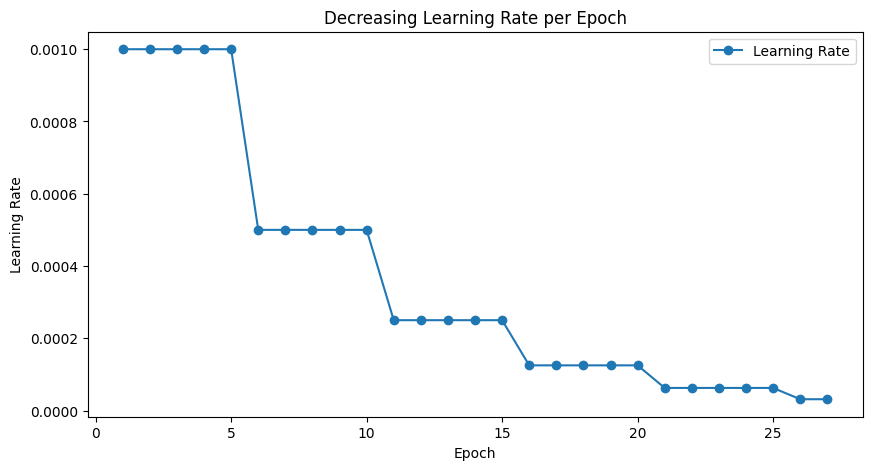

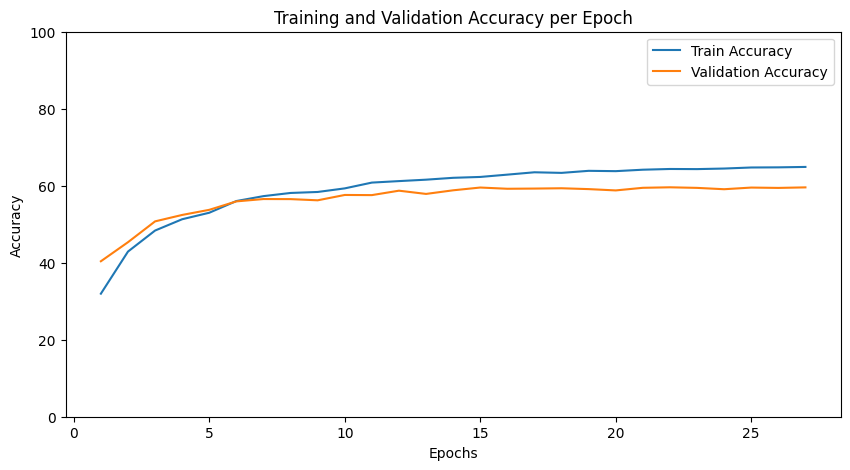

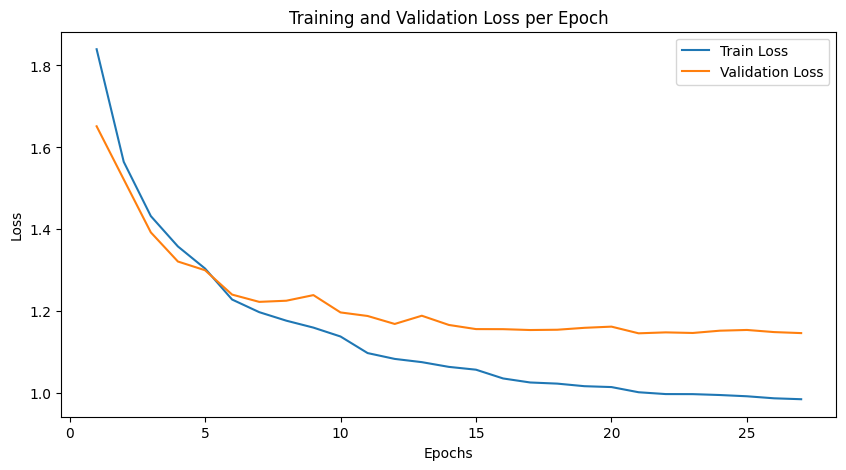

In [ ]:
model = LeNet(num_classes)
print(model)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model, trainDL=trainDL, valDL=valDL, epochs=100, save_path="/CIFAR10.pt"
)

## CIFAR10_model1 training


LeNet1(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Linear(in_features=400, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 1/100, Train Loss:1.5244, Train Accuracy:44.94%, Val Loss:1.4107, Val Acc:49.40%
Epoch 2/100, Train Loss:1.2731, Train Accuracy:54.35%, Val Loss:1.2460, Val Acc:55.78%
Epoch 3/100, Train Loss:1.1774, Train Accuracy:58.11%, Val Loss:1.1751, Val Acc:57.81%
Epoch 4/100, Train Loss:1.0987, Train Accura

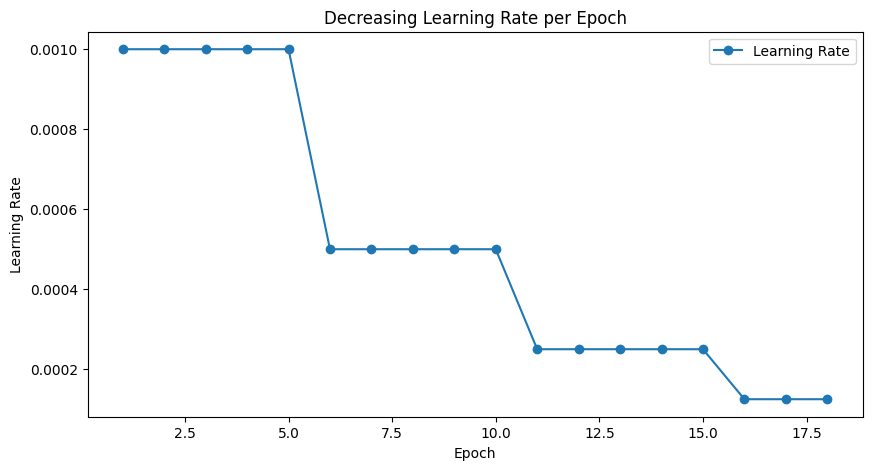

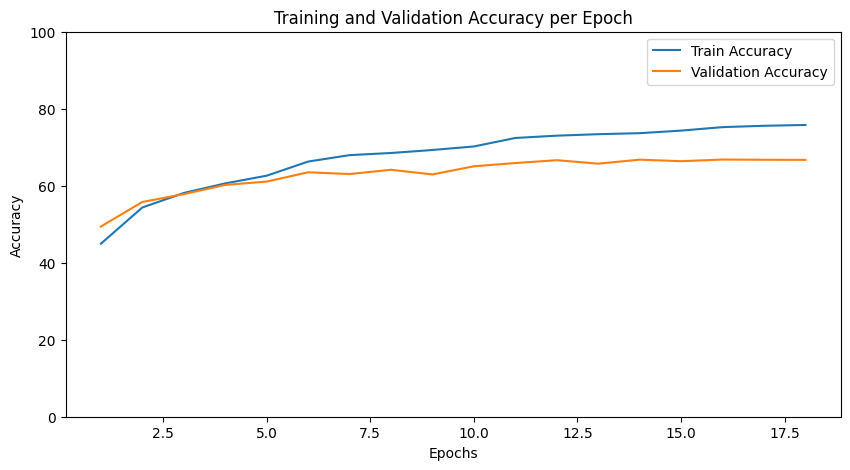

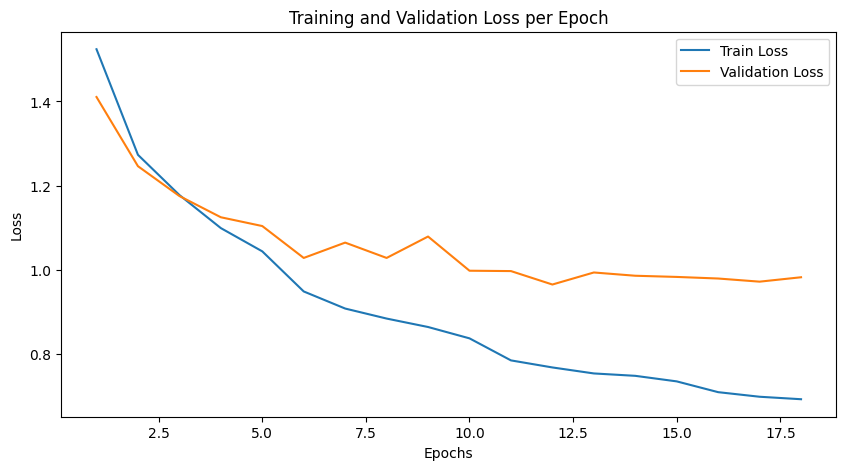

In [ ]:
model1 = LeNet1(num_classes)
print(model1)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model1,
    trainDL=trainDL,
    valDL=valDL,
    epochs=100,
    save_path="/CIFAR10_model1.pt",
)

## CIFAR10_model2 training


LeNet2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Linear(in_features=400, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
Epoch 1/100, Train Loss:1.5584, Train Accuracy:43.92%, Val Loss:1.4203, Val Acc:49.49%
Epoch 2/100, Train Loss:1.3247, Train Accuracy:52.81%, Val Loss:1.2896, Val Acc:54.14%
Epoch 3/100, Train Loss:1.2250, Train Accuracy:56.79%, Val Loss:1.1478, Val Acc:59.44%
Epo

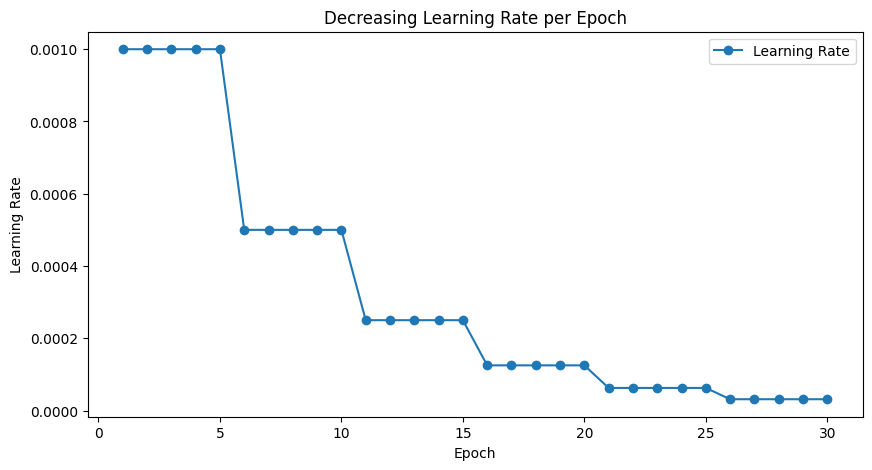

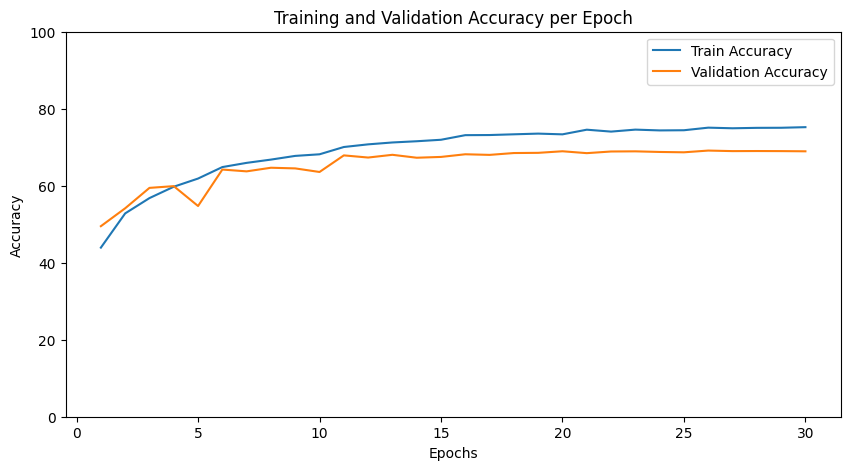

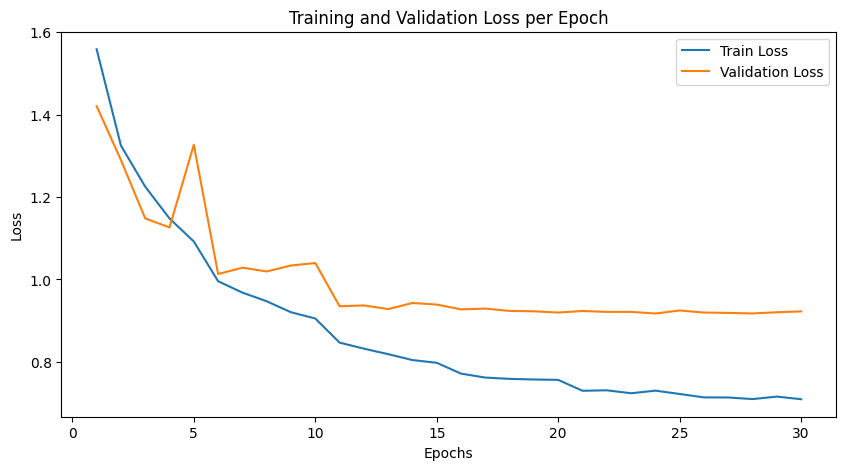

In [ ]:
model2 = LeNet2(num_classes)
print(model2)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model2,
    trainDL=trainDL,
    valDL=valDL,
    epochs=100,
    save_path="/CIFAR10_model2.pt",
)

# Task 5


## Dataloaders CIFAR100


In [ ]:
# coarse label mapping
coarse_labels = np.array(
    [
        4,
        1,
        14,
        8,
        0,
        6,
        7,
        7,
        18,
        3,
        3,
        14,
        9,
        18,
        7,
        11,
        3,
        9,
        7,
        11,
        6,
        11,
        5,
        10,
        7,
        6,
        13,
        15,
        3,
        15,
        0,
        11,
        1,
        10,
        12,
        14,
        16,
        9,
        11,
        5,
        5,
        19,
        8,
        8,
        15,
        13,
        14,
        17,
        18,
        10,
        16,
        4,
        17,
        4,
        2,
        0,
        17,
        4,
        18,
        17,
        10,
        3,
        2,
        12,
        12,
        16,
        12,
        1,
        9,
        19,
        2,
        10,
        0,
        1,
        16,
        12,
        9,
        13,
        15,
        13,
        16,
        19,
        2,
        4,
        6,
        19,
        5,
        5,
        8,
        19,
        18,
        1,
        2,
        15,
        6,
        0,
        17,
        8,
        14,
        13,
    ]
)


# CIFAR20 dataset class
class CIFAR20(torchvision.datasets.CIFAR100):
    def __init__(
        self,
        root="./data",
        train=True,
        download=False,
        transform=None,
        target_transform=None,
    ):
        super(CIFAR20, self).__init__(
            root=root,
            train=train,
            transform=transform,
            target_transform=target_transform,
            download=download,
        )

        # replace fine labels with coarse labels (20 superclasses)
        self.targets = coarse_labels[np.array(self.targets)]

In [ ]:
train_dataset = CIFAR20(
    root="./data", train=True, download=True, transform=transforms.ToTensor()
)
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [40000, 10000])

trainDL100 = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valDL100 = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

100%|██████████| 169M/169M [00:12<00:00, 13.4MB/s]


## CIFAR100_model training


LeNet2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Linear(in_features=400, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=84, out_features=20, bias=True)
)
Epoch 1/100, Train Loss:2.4690, Train Accuracy:24.11%, Val Loss:2.2491, Val Acc:30.67%
Epoch 2/100, Train Loss:2.2218, Train Accuracy:31.23%, Val Loss:2.1231, Val Acc:34.48%
Epoch 3/100, Train Loss:2.1173, Train Accuracy:34.57%, Val Loss:2.0958, Val Acc:36.06%
Epo

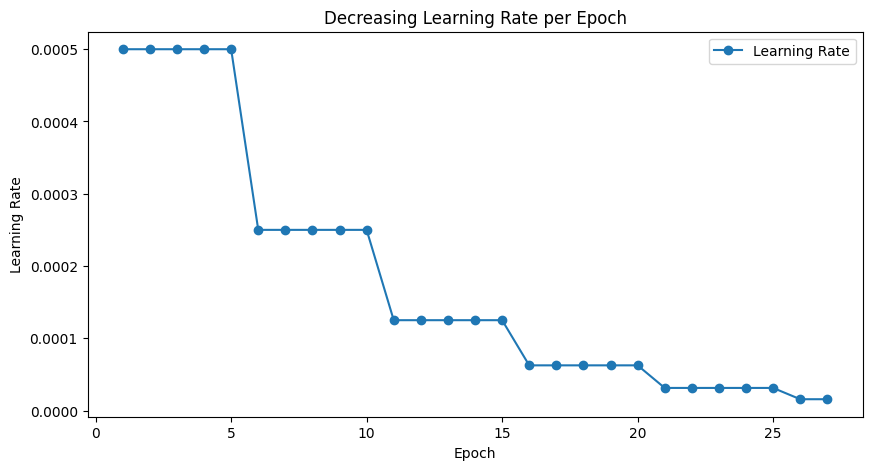

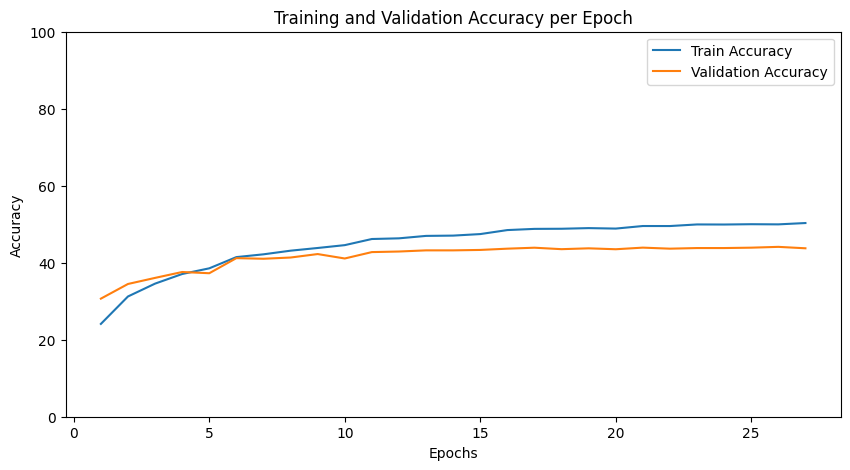

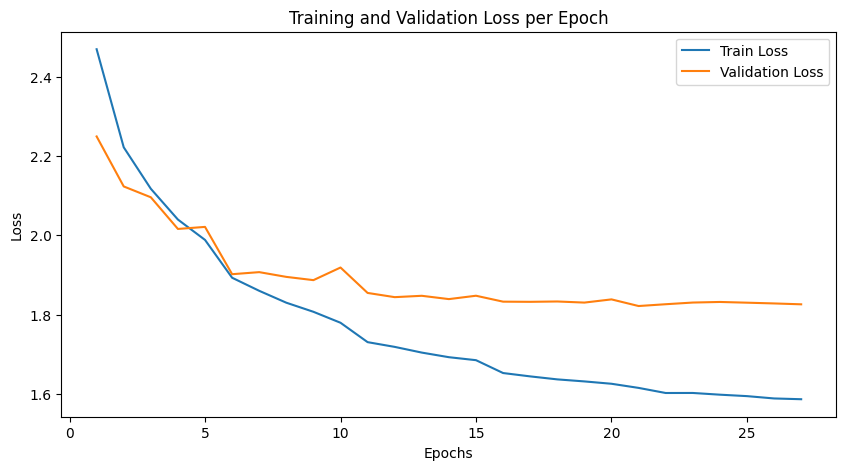

In [ ]:
model3 = LeNet2(num_classes=20)  # use architecture
print(model3)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model3,
    trainDL=trainDL100,
    valDL=valDL100,
    epochs=100,
    lr=0.0005,
    save_path="/CIFAR100_model.pt",
)

## Load weights to smaller network


In [ ]:
model_pretrained = LeNet2(num_classes=20)
# print(model_pretrained)
model_pretrained.load_state_dict(torch.load("/CIFAR100_model.pt", weights_only=True))
# replace last layer and initialize weights
model_pretrained.fc2 = nn.Linear(84, 10)
torch.nn.init.kaiming_normal_(model_pretrained.fc2.weight)
print(model_pretrained)

LeNet2(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Linear(in_features=400, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


## Finetune on CIFAR10


Epoch 1/100, Train Loss:1.5221, Train Accuracy:44.91%, Val Loss:1.3241, Val Acc:52.10%
Epoch 2/100, Train Loss:1.2884, Train Accuracy:53.82%, Val Loss:1.2585, Val Acc:54.98%
Epoch 3/100, Train Loss:1.1859, Train Accuracy:57.78%, Val Loss:1.1930, Val Acc:57.34%
Epoch 4/100, Train Loss:1.1205, Train Accuracy:60.05%, Val Loss:1.2322, Val Acc:56.41%
Epoch 5/100, Train Loss:1.0711, Train Accuracy:62.13%, Val Loss:1.0505, Val Acc:62.91%
Learning rate decreased
Epoch 6/100, Train Loss:0.9697, Train Accuracy:65.82%, Val Loss:0.9744, Val Acc:65.28%
Epoch 7/100, Train Loss:0.9445, Train Accuracy:66.45%, Val Loss:1.0133, Val Acc:63.65%
Epoch 8/100, Train Loss:0.9191, Train Accuracy:67.33%, Val Loss:0.9745, Val Acc:65.59%
Epoch 9/100, Train Loss:0.9025, Train Accuracy:68.15%, Val Loss:0.9591, Val Acc:66.02%
Epoch 10/100, Train Loss:0.8812, Train Accuracy:68.98%, Val Loss:0.9797, Val Acc:65.62%
Learning rate decreased
Epoch 11/100, Train Loss:0.8341, Train Accuracy:70.64%, Val Loss:0.9223, Val Acc:

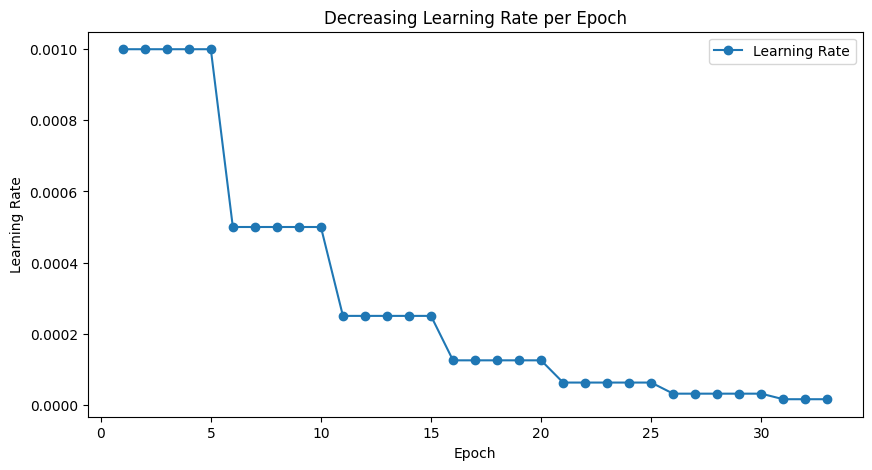

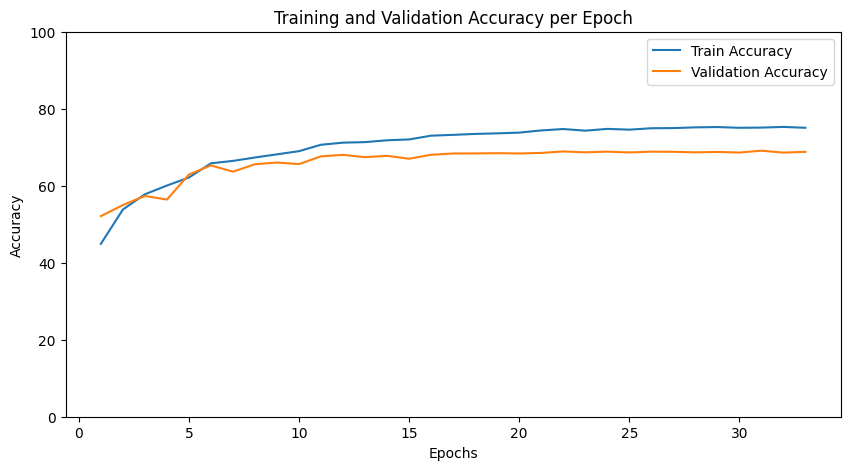

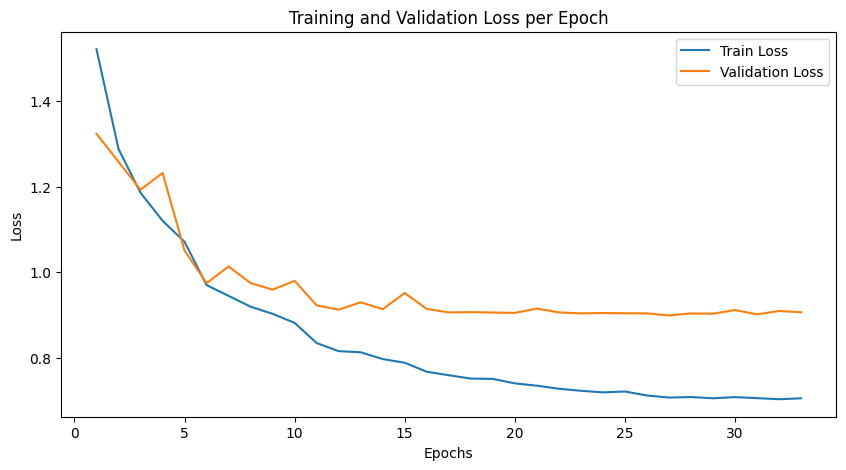

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model_pretrained,
    trainDL=trainDL,
    valDL=valDL,
    epochs=100,
    save_path="/CIFAR10_pretrained.pt",
)

# Task 6


In [ ]:
model2.load_state_dict(torch.load("/CIFAR10_model2.pt", weights_only=False))
model_pretrained.load_state_dict(
    torch.load("/CIFAR10_pretrained.pt", weights_only=False)
)

acc_model2, cm_model2 = evaluate(model2, testDL)
print(f"test accuracy CIFAR10_model2: {acc_model2}%")
print(f"Confusion Matrix CIFAR10_model2:\n{cm_model2}")
acc_pretrained, cm_pretrained = evaluate(model_pretrained, testDL)
print(f"test accuracy CIFAR10_pretrained: {acc_pretrained}%")
print(f"Confusion Matrix CIFAR10_pretrained:\n{cm_pretrained}")

test accuracy CIFAR10_model2: 67.81%
Confusion Matrix CIFAR10_model2:
[[721  34  53  24  20   9  10  14  70  45]
 [ 16 825  13   9   2   7  10   4  27  87]
 [ 69   9 532  76 130  66  49  38  16  15]
 [ 21  23  72 474  81 170  82  49  11  17]
 [ 17   9  92  50 618  35  52 106  10  11]
 [ 11   8  58 187  64 569  26  66   2   9]
 [  8  12  48  73  59  25 743  17   6   9]
 [ 13   4  26  32  64  57   8 769   4  23]
 [ 71  49  19  12  16   5   8   3 780  37]
 [ 29 103  13  20  10  13   9  25  28 750]]
test accuracy CIFAR10_pretrained: 68.6%
Confusion Matrix CIFAR10_pretrained:
[[764  26  39  16  21   4  10  10  74  36]
 [ 16 824  12   7   7   2   8   5  36  83]
 [ 77   6 559  68 104  54  62  38  21  11]
 [ 28  20  83 461  86 171  62  43  22  24]
 [ 25   6  81  61 626  40  56  78  21   6]
 [ 15   1  69 195  67 541  25  70   8   9]
 [  8   8  57  80  48  25 741  10  12  11]
 [ 14   4  34  52  57  56  10 759   1  13]
 [ 64  43  15  11   9   4   5   1 817  31]
 [ 37  97  10  13   4   3  10  21  

## Choice Tasks 7,8: Tiny ImageNet


In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip

In [ ]:
# mapping to CIFAR10 classes
tiny_to_cifar = {
    "n02691156": 0,  # Airplane
    "n02814533": 1,  # Car
    "n01558993": 2,  # Bird
    "n02121620": 3,  # Cat
    "n02415577": 4,  # Deer
    "n02099712": 5,  # Dog
    "n01641577": 6,  # Frog
    "n02389026": 7,  # Horse
    "n04133789": 8,  # Ship
    "n03417042": 9,  # Truck
}


class TinyImageNet(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        for tiny_class, cifar_class in tiny_to_cifar.items():
            class_dir = os.path.join(root_dir, tiny_class, "images")
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.samples.append((img_path, cifar_class))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

## Evaluate cross-dataset performance


In [ ]:
tiny_transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)
# load Tiny Imagenet dataset
tiny_dataset = TinyImageNet(
    root_dir="tiny-imagenet-200/train", transform=tiny_transform
)
# split to train and val
train_size = int(len(tiny_dataset) * 0.8)
val_size = len(tiny_dataset) - train_size
tiny_train, tiny_val = torch.utils.data.random_split(
    tiny_dataset, [train_size, val_size]
)

tiny_loader_val = DataLoader(tiny_val, batch_size=32, shuffle=True)
# load CIFAR10 trained model
model_fn = LeNet2(num_classes=10)
model_fn.load_state_dict(torch.load("/CIFAR10_model2.pt", weights_only=True))
# evaluate on tiny imagenet
acc_before, cm_before = evaluate(model_fn, tiny_loader_val)
print(f"Accuracy: {acc_before}%")
print(f"Confusion Matrix:\n{cm_before}")

Accuracy: 38.2%
Confusion Matrix:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 8 69  3  4  2  0  0  0 10 11]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 6  0 13 10 33  4 10 17  1  1]
 [ 0  3 10 26  9 34  6 12  1  4]
 [ 5  4 13  5 15  1 49  2  1  4]
 [ 0  0  0  0  0  0  0  0  0  0]
 [13  6 11 25  6  9  6  5  6  7]
 [ 0  0  0  0  0  0  0  0  0  0]]


## Finetune on TinyImagenet


Epoch 1/50, Train Loss:1.5067, Train Accuracy:54.30%, Val Loss:1.1583, Val Acc:59.20%
Epoch 2/50, Train Loss:0.9042, Train Accuracy:67.35%, Val Loss:1.1521, Val Acc:57.00%
Epoch 3/50, Train Loss:0.7485, Train Accuracy:71.50%, Val Loss:1.2134, Val Acc:55.00%
Epoch 4/50, Train Loss:0.6397, Train Accuracy:76.65%, Val Loss:1.3279, Val Acc:55.80%
Epoch 5/50, Train Loss:0.5477, Train Accuracy:79.65%, Val Loss:1.1437, Val Acc:61.80%
Learning rate decreased
Epoch 6/50, Train Loss:0.4193, Train Accuracy:85.40%, Val Loss:1.1111, Val Acc:62.40%
Epoch 7/50, Train Loss:0.3918, Train Accuracy:86.25%, Val Loss:1.1573, Val Acc:62.80%
Epoch 8/50, Train Loss:0.3577, Train Accuracy:86.95%, Val Loss:1.2475, Val Acc:58.80%
Epoch 9/50, Train Loss:0.3083, Train Accuracy:89.80%, Val Loss:1.2094, Val Acc:62.00%
Epoch 10/50, Train Loss:0.2941, Train Accuracy:89.05%, Val Loss:1.2541, Val Acc:62.80%
Learning rate decreased
Epoch 11/50, Train Loss:0.2355, Train Accuracy:93.15%, Val Loss:1.2465, Val Acc:63.00%
Epoc

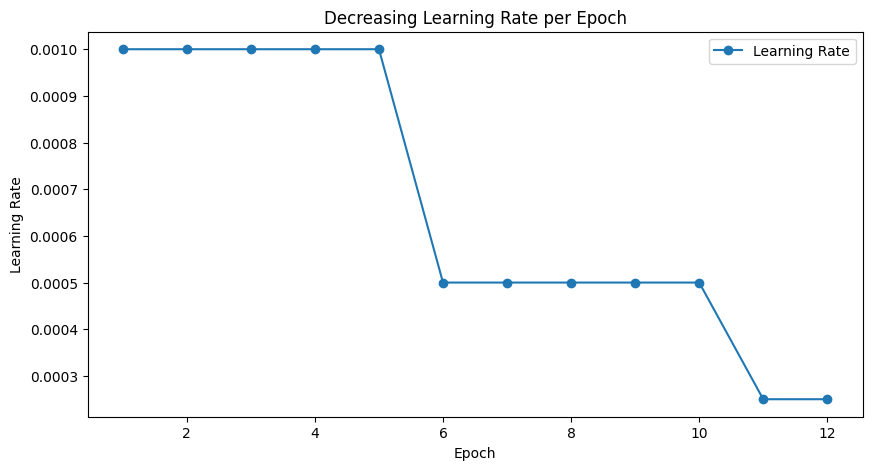

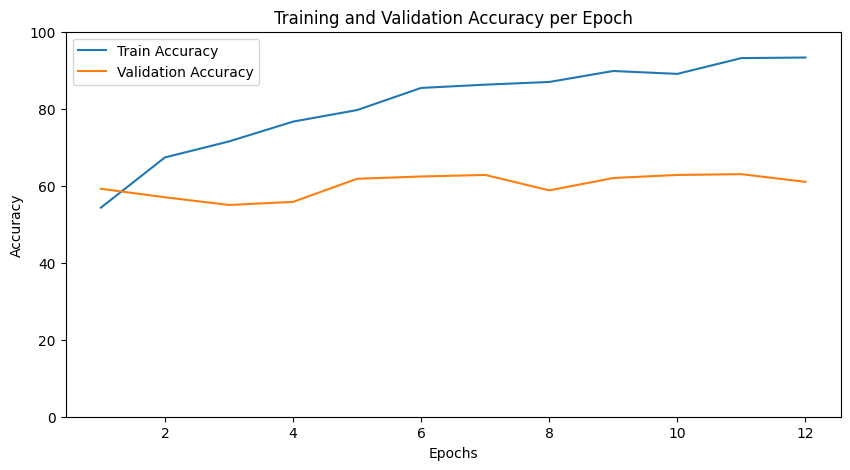

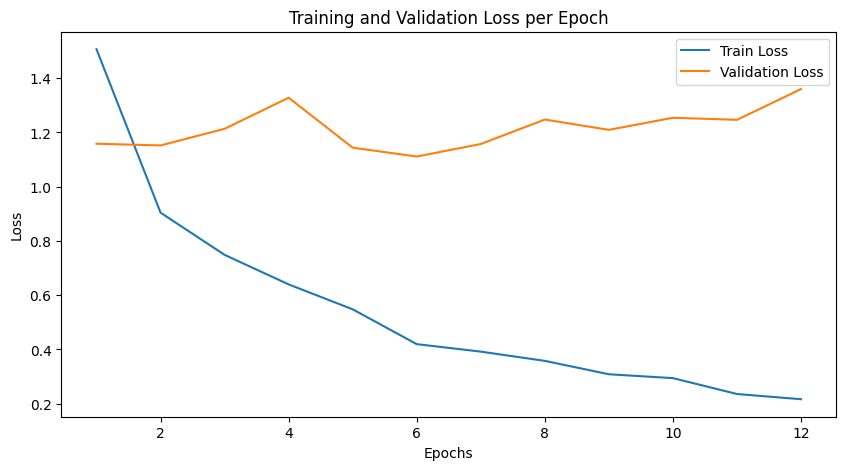

Accuracy: 61.0%
Confusion Matrix:
[[89  2  2  5  9]
 [ 2 60 11 14  8]
 [ 7 27 35  8 28]
 [ 9  9  4 73  4]
 [11 15 12  8 48]]


In [ ]:
# load model trained on CIFAR10
model_new = LeNet2(num_classes=10)
model_new.load_state_dict(torch.load("/CIFAR10_model2.pt", weights_only=True))
# train dataloader
tiny_loader = DataLoader(tiny_train, batch_size=32, shuffle=True)

# finetune
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model=model_new,
    trainDL=tiny_loader,
    valDL=tiny_loader_val,
    epochs=50,
    save_path="/CIFAR10_model2_tiny.pt",
)
# evaluate again on tiny imagenet
acc_tr, cm_tr = evaluate(model_new, tiny_loader_val)
print(f"Accuracy: {acc_tr}%")
print(f"Confusion Matrix:\n{cm_tr}")